In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, ParameterGrid,KFold
from sklearn.utils.class_weight import compute_class_weight

from sklearn.preprocessing import LabelEncoder

import xgboost as xgb

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from ipywidgets import IntProgress
from IPython.display import display

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load data

In [4]:
DIR  = "/gdrive/MyDrive/Data_Science_Projekte/earth_quake_damage_dd/"

train_values = pd.read_csv(DIR+'data/train_values.csv', index_col='building_id')
train_labels = pd.read_csv(DIR+'data/train_labels.csv', index_col='building_id')
test_values  = pd.read_csv(DIR+"data/test_values.csv", index_col='building_id')
submission_format = pd.read_csv(DIR+"data/submission_format.csv", index_col='building_id')

train_data = train_values.join(train_labels)
train_data.head(5)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3
28830,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,2
94947,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3
590882,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,2
201944,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,3


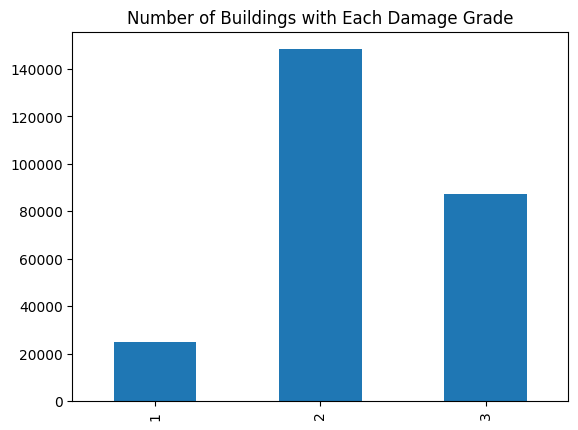

In [5]:
(train_labels.damage_grade.value_counts().sort_index()
    .plot.bar(title="Number of Buildings with Each Damage Grade"))
plt.show()

In [6]:
train_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-

# Geo Embedding

In [7]:
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

In [8]:
# Step 1: Label Encoding
X = pd.concat([train_values, test_values]).loc[:,geo_features].drop_duplicates()

label_encoders = {}
encoded_data = {}

for column in X.columns:
    le = LabelEncoder()
    encoded_data[column] = le.fit_transform(X[column])
    label_encoders[column] = le

encoded_df = pd.DataFrame(encoded_data)

input_data = torch.tensor(encoded_df.values, dtype=torch.long)
output_data = input_data.clone()

In [13]:
for column in X.columns:
  print(X.loc[:, column].unique().size)

31
1418
11861


In [14]:
# Step 2: Define the Neural Network
class GeoEncoderModel(nn.Module):
    def __init__(self,
                 emb_dim: int=16,
                 num_classes1: int=31,
                 num_classes2: int=1418,
                 num_classes3: int=11861):
        super().__init__()
        self.geo_lv1_embedder = nn.Embedding(num_classes1, 16)
        self.geo_lv2_embedder = nn.Embedding(num_classes2, 512)
        self.geo_lv3_embedder = nn.Embedding(num_classes3, 1024)
        self.compressor = torch.nn.Linear(16+512+1024, emb_dim)

    def forward(self, x):
        x_1 = self.geo_lv1_embedder(x[:, 0])
        x_2 = self.geo_lv2_embedder(x[:, 1])
        x_3 = self.geo_lv3_embedder(x[:, 2])
        x = torch.concat((x_1, x_2, x_3), dim=1)
        x = torch.nn.functional.relu(x)
        return self.compressor(x)

class GeoDecoderModel(nn.Module):
    def __init__(self,
                 emb_dim: int=16,
                 num_classes1: int=31,
                 num_classes2: int=1418,
                 num_classes3: int=11861):
        super().__init__()
        self.geo_lv1_predictor = nn.Linear(emb_dim, num_classes1)
        self.geo_lv2_predictor = nn.Linear(emb_dim, num_classes2)
        self.geo_lv3_predictor = nn.Linear(emb_dim, num_classes3)

    def forward(self, x):
        x1 = self.geo_lv1_predictor(x)
        x2 = self.geo_lv2_predictor(x)
        x3 = self.geo_lv3_predictor(x)
        return x1, x2, x3

class GeoEncoderDecoderModel(nn.Module):
    def __init__(self,
                 emb_dim: int=16,
                 num_classes1: int=31,
                 num_classes2: int=1418,
                 num_classes3: int=11861):
        super().__init__()
        self.encoder = GeoEncoderModel(emb_dim, num_classes1, num_classes2, num_classes3)
        self.decoder = GeoDecoderModel(emb_dim, num_classes1, num_classes2, num_classes3)

    def forward(self, x):
        x = self.encoder(x)
        x = nn.functional.relu(x)
        x1, x2, x3 = self.decoder(x)
        return x1, x2, x3

In [15]:
# Step 3: Training

# Create the neural network model
model = GeoEncoderDecoderModel().to(DEVICE)

batch_size = 512  # You can adjust this based on your available memory and computational resources
dataset = TensorDataset(input_data, output_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterions = []
for column in geo_features:
    weight = compute_class_weight('balanced',
                                  classes=X[column].unique(),
                                  y=X[column].values
    )
    weight = torch.tensor(weight, dtype=torch.float).to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight)
    criterions.append(criterion)

# Train the model
num_epochs = 500  # You can adjust this based on your data size and convergence
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, targets in dataloader:
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = 0
        for i in range(3):
          loss += criterions[i](outputs[i], targets[:,i])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if ((epoch % 50 == 0) or (epoch == num_epochs -1)):
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader):.6f}")


Epoch [1/500], Loss: 19.981571
Epoch [51/500], Loss: 2.558915
Epoch [101/500], Loss: 0.400990
Epoch [151/500], Loss: 0.076937
Epoch [201/500], Loss: 0.204342
Epoch [251/500], Loss: 0.010850
Epoch [301/500], Loss: 0.008511
Epoch [351/500], Loss: 0.019665
Epoch [401/500], Loss: 0.003311
Epoch [451/500], Loss: 0.002190
Epoch [500/500], Loss: 0.002582


In [16]:
# Step 4: Extract the Embedding
# Now that the model is trained, you can get the embeddings for your original data

for df in [train_values, test_values]:
    encoded_data = {}

    for column in geo_features:
        le = label_encoders[column]
        encoded_data[column] = le.transform(df[column])

    encoded_df = pd.DataFrame(encoded_data)

    input_data = torch.tensor(encoded_df.values, dtype=torch.long).to(DEVICE)

    with torch.no_grad():
        embedding = torch.relu(model.encoder(input_data))

    embedding = np.array(embedding.to('cpu'))

    for j in range(16):
        df ['geo_' + str(j+1)] = embedding[:,j]

    df.drop(columns=geo_features, inplace=True) #check if really deleted and if we want this

In [17]:
train_values.head()

,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,...,geo_7,geo_8,geo_9,geo_10,geo_11,geo_12,geo_13,geo_14,geo_15,geo_16
building_id,,,,,,,,,,,,,,,,,,,,,
802906,2,30,6,5,t,r,n,f,q,t,...,157.994141,0.0,0.0,0.0,76.162865,95.642845,0.0,0.0,119.734184,20.180653
28830,2,10,8,7,o,r,n,x,q,s,...,36.295059,0.0,0.0,0.0,110.341232,137.050980,0.0,0.0,53.389877,120.957504
94947,2,10,5,5,t,r,n,f,x,t,...,155.421600,0.0,0.0,0.0,119.980019,16.173512,0.0,0.0,116.151787,87.589844
590882,2,10,6,5,t,r,n,f,x,s,...,155.926300,0.0,0.0,0.0,78.824173,7.863626,0.0,0.0,87.893898,18.620155
201944,3,30,8,9,t,r,n,f,x,s,...,30.819769,0.0,0.0,0.0,189.682785,19.209997,0.0,0.0,144.321335,65.518547


In [39]:
#torch.save(model.encoder.state_dict(), DIR + 'dim-reduction-16-large-w.pt')

# Search for best hyperparameters

In [19]:
param_grid = {'objective': ['multi:softmax'],
              'random_state': [42],
              'n_estimators': [500],
              'learning_rate': [0.1],
              'max_depth': [10, 12],
              'min_child_weight':[50],
              'min_split_loss': [0],
              'colsample_bytree': [0.75, 0.8]
}

param_list = list(ParameterGrid(param_grid))

print('Size of ParameterGrid: ', len(param_list))

Size of ParameterGrid:  4


In [20]:
X = pd.get_dummies(train_values)
y = train_labels.values.ravel() - 1

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

best_score = 0
results = []

f = IntProgress(min=0, max=len(param_list)) #progress bar
display(f)

for i, params in enumerate(param_list):
    if DEVICE == "cuda":
        xgb_model = xgb.XGBClassifier(tree_method='gpu_hist', **params)
    else:
        xgb_model = xgb.XGBClassifier(**params)
    xgb_model.fit(X_train, y_train)

    df = pd.DataFrame(data=params, index = [i])

    pred_y_train = xgb_model.predict(X_train)
    train_score = f1_score(y_train, pred_y_train, average='micro')
    df['train_score'] = train_score

    pred_y_val = xgb_model.predict(X_val)
    val_score = f1_score(y_val, pred_y_val, average='micro')
    df['val_score'] = val_score

    results.append(df)

    if val_score > best_score:
        best_score = val_score
        best_model = xgb_model
        best_params = params

    f.value += 1

IntProgress(value=0, max=4)

In [21]:
print('best parameter:', best_params)
print('best val score:', best_score)

best parameter: {'colsample_bytree': 0.75, 'learning_rate': 0.1, 'max_depth': 12, 'min_child_weight': 50, 'min_split_loss': 0, 'n_estimators': 500, 'objective': 'multi:softmax', 'random_state': 42}
best val score: 0.7485850233111415


In [22]:
df_results = pd.concat(results).drop(columns=['objective', 'random_state'])
df_results.sort_values(by='val_score',ascending=False).head(10)

,colsample_bytree,learning_rate,max_depth,min_child_weight,min_split_loss,n_estimators,train_score,val_score
1,0.75,0.1,12,50,0,500,0.830444,0.748585
0,0.75,0.1,10,50,0,500,0.810145,0.747990
3,0.80,0.1,12,50,0,500,0.829821,0.747645
2,0.80,0.1,10,50,0,500,0.810711,0.747626


81


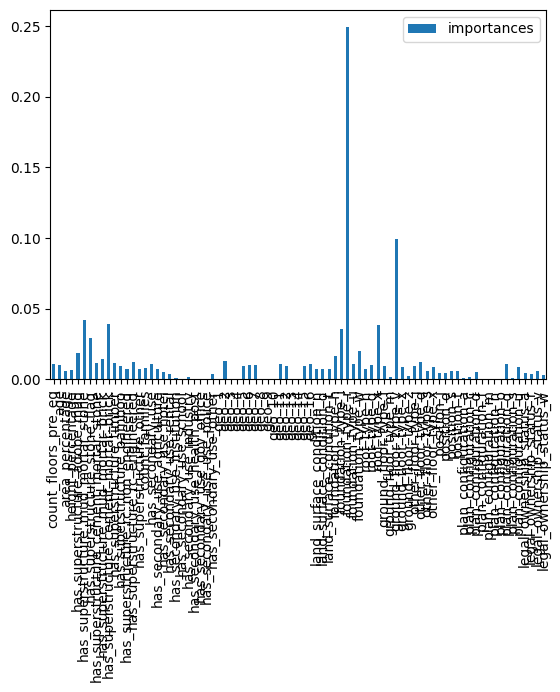

In [31]:
#get feature importances and graph, could look further into thesee to improve the model further
df_importances=pd.DataFrame(best_model.feature_importances_)
df_importances.index=X.columns
df_importances.columns=['importances']
print(df_importances.size)
df_importances.plot.bar()
plt.show()

In [32]:
important_features = df_importances.sort_values(by='importances', ascending=False).iloc[:70].index

In [33]:
X = pd.get_dummies(train_values).loc[:, important_features]
y = train_labels.values.ravel() - 1

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

train_scores = []
val_scores = []

for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

    if DEVICE == "cuda":
      xgb_model = xgb.XGBClassifier(tree_method='gpu_hist',**best_params)
    else:
      xgb_model = xgb.XGBClassifier(**best_params)
    xgb_model.fit(X_train, y_train)

    train_y_pred = xgb_model.predict(X_train)
    train_scores.append(f1_score(y_train, train_y_pred, average='micro'))

    val_y_pred = xgb_model.predict(X_test)
    val_scores.append(f1_score(y_test, val_y_pred, average='micro'))

print('training score: {0: .5f}'.format(np.mean(train_scores)))
print('validation score: {0: .5f}'.format(np.mean(val_scores)))

training score:  0.82973
validation score:  0.74857


# Final training and prediction

In [34]:
X_train = pd.get_dummies(train_values).loc[:, important_features]
X_test = pd.get_dummies(test_values).loc[:, important_features]
y_train = train_labels.values.ravel() - 1

if DEVICE == "cuda":
    xgb_model = xgb.XGBClassifier(tree_method='gpu_hist',**best_params)
else:
    xgb_model = xgb.XGBClassifier(**best_params)
xgb_model.fit(X_train, y_train)

pred_y_train = xgb_model.predict(X_train)
train_score = f1_score(y_train, pred_y_train, average='micro')
print('training score: {0: .5f}'.format(train_score))

training score:  0.82461


In [35]:
predictions = xgb_model.predict(X_test) + 1

# Save submission

In [36]:
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [37]:
my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3


In [38]:
my_submission.to_csv(DIR+'submissions/submission_first.csv')